# Поиск зависимостей параметров друг от друга, полученных в результате ГИС для дальнейшего предсказания их величин

In [276]:
import math
import sys
import scipy as sp
import IPython
import sklearn
import numpy as np
import pandas as pd
import mglearn 
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy import sparse
from scipy.linalg import inv,pinv
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures




In [277]:
df = pd.read_csv('log.csv',sep=",",index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8739 entries, 195.0 to 4808.0
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RxoRt   8739 non-null   float64
 1   RLL3    8739 non-null   float64
 2   SP      8739 non-null   float64
 3   RILD    8739 non-null   float64
 4   MN      8739 non-null   float64
 5   MI      8739 non-null   float64
 6   MCAL    8739 non-null   float64
 7   DCAL    8739 non-null   float64
 8   RHOB    8739 non-null   float64
 9   RHOC    8739 non-null   float64
 10  DPOR    8739 non-null   float64
 11  CNLS    8739 non-null   float64
 12  GR      8739 non-null   float64
dtypes: float64(13)
memory usage: 955.8 KB


Имеем файл в виде таблицы с 13 столбцами и 8739 строками.

In [288]:

df

,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,DPOR,CNLS,GR
Depth,,,,,,,,,,,,,
195.0,226.0848,0.4076,69.8953,132.5052,-0.3548,0.1863,5.1090,1.8878,1.6973,-0.6303,59.2216,30.0657,60.4576
195.5,223.5031,0.4063,69.2303,123.6225,-0.3619,0.1867,5.1031,1.8882,1.6791,-0.6409,60.2877,26.7625,54.1495
196.0,221.4560,0.4047,68.4478,116.9258,-0.3668,0.1860,5.0872,1.8878,1.6585,-0.6539,61.4914,27.6017,51.9944
196.5,219.8248,0.4033,67.4843,111.7925,-0.3613,0.1867,5.0881,1.8884,1.6435,-0.6649,62.3711,31.5870,52.9645
197.0,218.1438,0.4023,66.3013,106.7821,-0.3569,0.1870,5.0972,1.8883,1.6390,-0.6705,62.6343,35.8251,54.9659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4806.0,1.1354,398.8031,-125.7813,412.4244,42.3643,46.5066,7.8238,6.2264,2.5519,0.2965,9.2449,0.0675,25.8831
4806.5,1.5895,487.2287,-126.0632,434.0304,41.9099,43.5448,7.8055,6.2264,2.5503,0.2977,9.3399,0.0704,9.4402
4807.0,4.1163,464.9174,-126.3459,454.8452,58.5249,57.1680,7.8325,6.2250,2.5500,0.2988,9.3589,0.1168,1.7368


Датасет был взят с kaggle, представляет собой данные ГИСов. Однако, никакой дополнительной информации предоставлено не было, все столбцы обозначены на английском, из-за чего возникли сомнения, за что конкретно отвечают некоторые параметры. Поэтому я не привожу теорию для зависимостей одних величин от других. Основная цель работы - поиск зависимостей параметров друг от друга с использованием линейной и полиномиальной регрессий.

RxoRt - Соотношение сопротивления ЗП и глубинной зоны
RLL3 - Данные бокового каротажа
SP - Собственный потенциал
RILD - Данные сопротивления индукционного каротажа
MN - Микропотенциал-зонд
MI - Микроградиент-зонд
MCAL - Данные кавернометрии для толщины ЗП
DCAL - Дифференциальная толщина ЗП
RHOB - Объёмная плотность
RHOC-?
DPOR -?
CNLS - Нейтронный Каротаж
GR - Гамма-каротаж

Для начала построим графики зависимости всех параметров от глубины

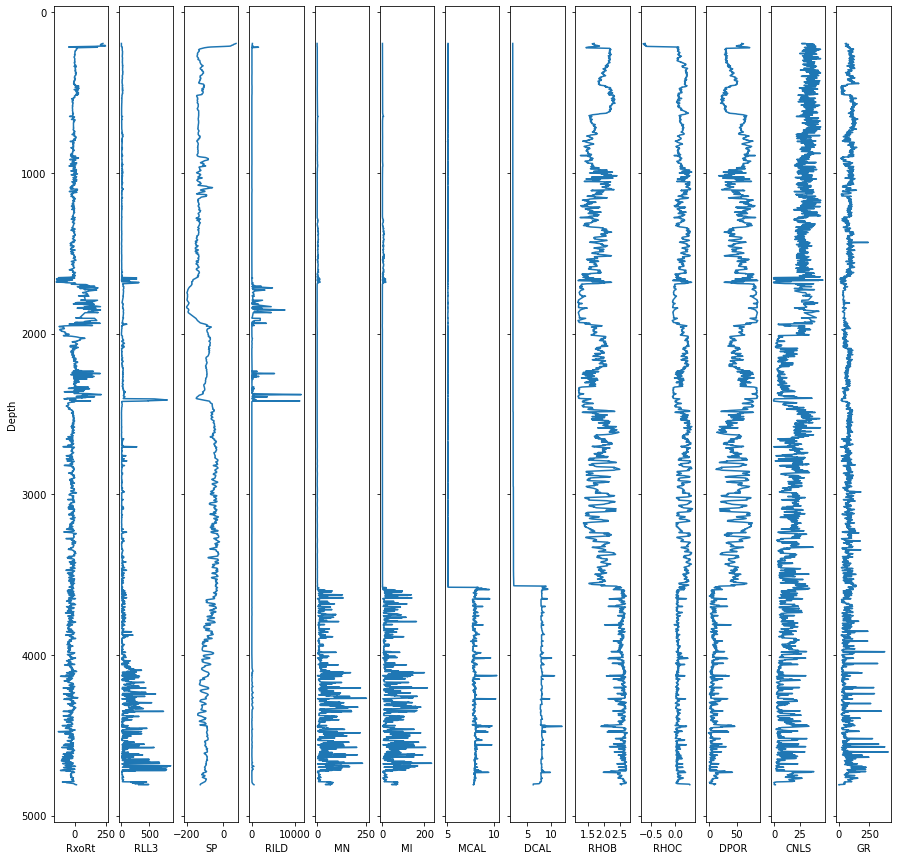

In [275]:
fig, ax = plt.subplots(1,13,sharey=True, figsize=(15, 15))
ax[0].plot(df.iloc[:,0], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[0].set_xlabel("RxoRt")
ax[0].set_ylabel("Depth")
ax[1].plot(df.iloc[:,1], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[1].set_xlabel("RLL3")
ax[2].plot(df.iloc[:,2], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[2].set_xlabel("SP")
ax[3].plot(df.iloc[:,3], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[3].set_xlabel("RILD")
ax[4].plot(df.iloc[:,4], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[4].set_xlabel("MN")
ax[5].plot(df.iloc[:,5], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[5].set_xlabel("MI")
ax[6].plot(df.iloc[:,6], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[6].set_xlabel("MCAL")
ax[7].plot(df.iloc[:,7], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[7].set_xlabel("DCAL")
ax[8].plot(df.iloc[:,8], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[8].set_xlabel("RHOB")
ax[9].plot(df.iloc[:,9], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[9].set_xlabel("RHOC")
ax[10].plot(df.iloc[:,10], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[10].set_xlabel("DPOR")
ax[11].plot(df.iloc[:,11], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[11].set_xlabel("CNLS")
ax[12].plot(df.iloc[:,12], df.index.tolist() )
plt.gca().invert_yaxis ()
ax[12].set_xlabel("GR")
plt.show()

Теперь построим корреляционную матрицу по всем параметрам

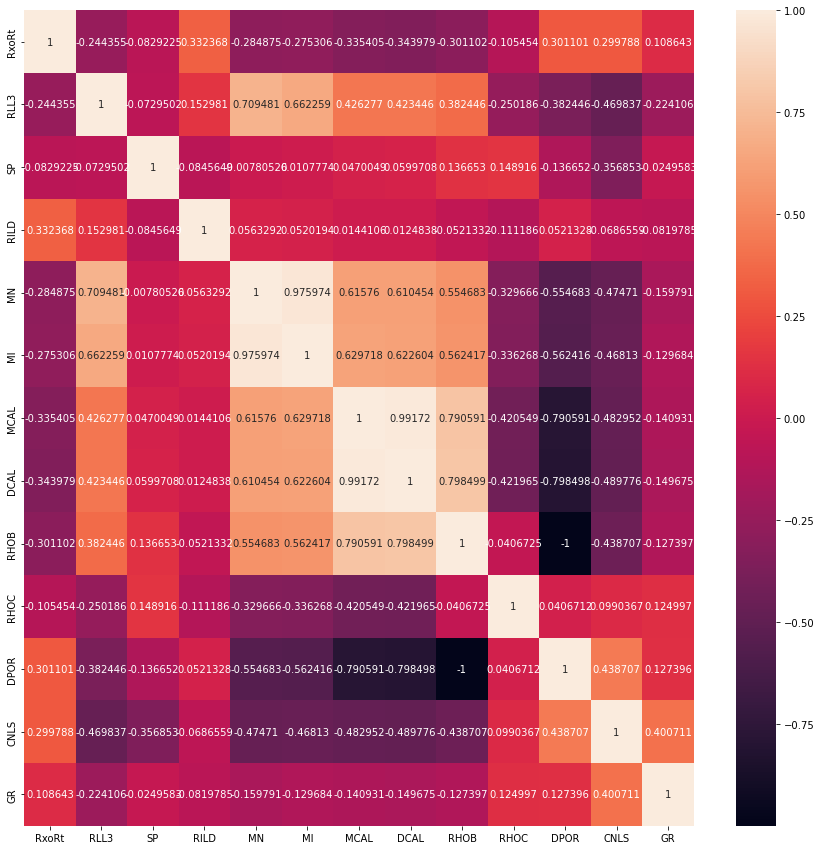

In [15]:
df_numpy = np.array(df).T
f=df.corr()

labs = ['RxoRt', 'RLL3', 'SP','RILD','MN','MI','MCAL','DCAL','RHOB','RHOC','DPOR','CNLS','GR']
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(f, annot=True, fmt='g', xticklabels=labs, yticklabels=labs,ax=ax)
plt.show()

Далее, убираю графики RILD,MI,DCAL,DPOR и CNLS. Убираю их из-за корреляции, которая по модулю >=0.8, а также из-за низкой информативности графиков. Рассмотрим оставшиеся параметры

In [257]:
df[['RxoRt','RLL3','SP','MN','MCAL','RHOB','RHOC','GR']]

,RxoRt,RLL3,SP,MN,MCAL,RHOB,RHOC,GR
Depth,,,,,,,,
195.0,226.0848,0.4076,69.8953,-0.3548,5.1090,1.6973,-0.6303,60.4576
195.5,223.5031,0.4063,69.2303,-0.3619,5.1031,1.6791,-0.6409,54.1495
196.0,221.4560,0.4047,68.4478,-0.3668,5.0872,1.6585,-0.6539,51.9944
196.5,219.8248,0.4033,67.4843,-0.3613,5.0881,1.6435,-0.6649,52.9645
197.0,218.1438,0.4023,66.3013,-0.3569,5.0972,1.6390,-0.6705,54.9659
...,...,...,...,...,...,...,...,...
4806.0,1.1354,398.8031,-125.7813,42.3643,7.8238,2.5519,0.2965,25.8831
4806.5,1.5895,487.2287,-126.0632,41.9099,7.8055,2.5503,0.2977,9.4402
4807.0,4.1163,464.9174,-126.3459,58.5249,7.8325,2.5500,0.2988,1.7368


### Далее, ищу зависимости между параметрами 

Строю диаграммы

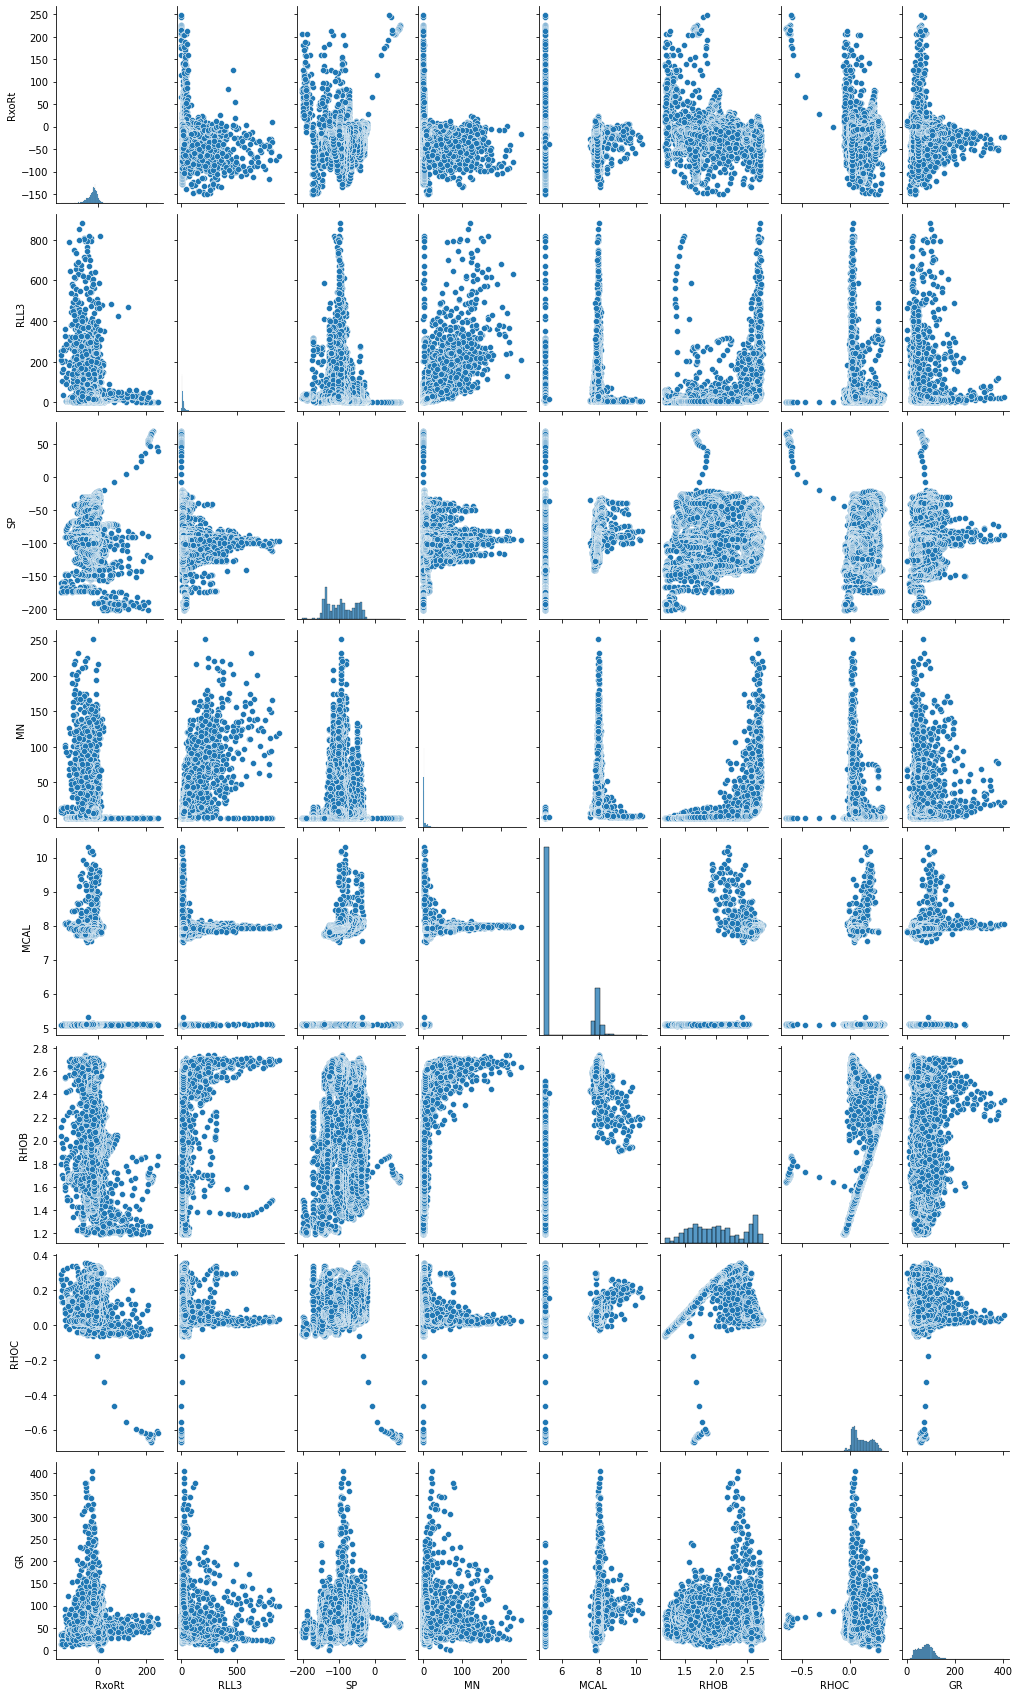

In [38]:
sns.pairplot(df[['RxoRt','RLL3','SP','MN','MCAL','RHOB','RHOC','GR']], height=3, aspect=0.6)
#f.fig.set_size_inches(10,10)


Из всех параметров я точно выделил параметр RHOC, который имеет небольшой объём точек, похожих на вылеты по значениям

Убираю все значения RHOC, ниже -0.1

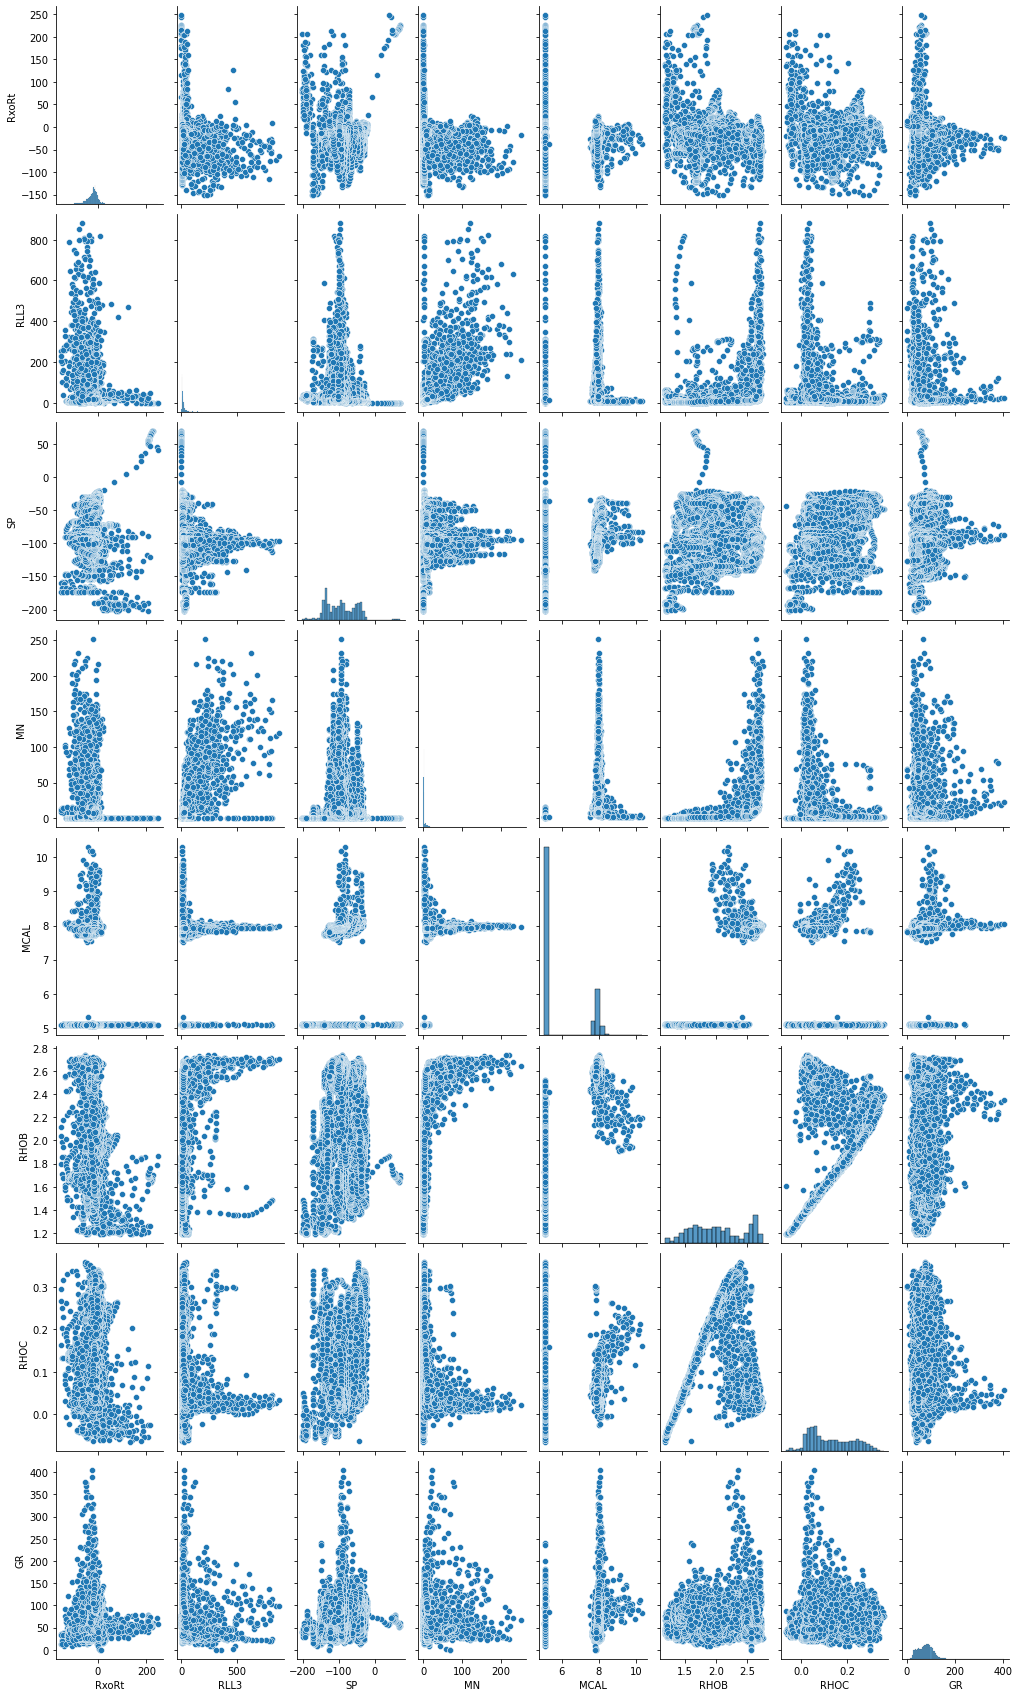

In [41]:
b=lambda x: x>(-0.1) #RHOC
df_part1_clear= df[['RxoRt','RLL3','SP','MN','MCAL','RHOB','RHOC','GR']].copy()
df_part1_clear['RHOC']= df['RHOC'][b]

sns.pairplot(df_part1_clear, height=3, aspect=0.6)

Далее, заполню отсутствующие значения в таблице и буду выполнять линейную регрессию, а также линейную регрессию с использованием полиномов различных степеней

### Линейная регрессия 

coefficient of determination(R^2):0.05970954785654492
intercept(b_0):26.193719296536024
slope(b_1):-0.6356364321194994


Text(0, 0.5, 'RLL3')

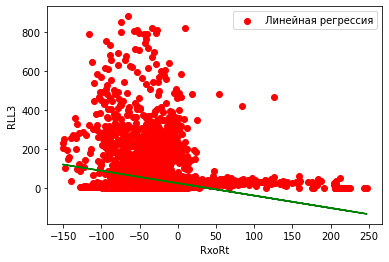

In [101]:
values = {'RHOC':0}
df_part1_clear=df_part1_clear.fillna(value=values)

x_0=df_part1_clear['RxoRt'].values
y_0=df_part1_clear['RLL3'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='red')
plt.plot( x, y_pred,'g-')
plt.legend(['Линейная регрессия'])
plt.xlabel('RxoRt')
plt.ylabel('RLL3')

Как видно, коэф детерминации около 0.06, что означает, что мы не можем хорошо описать 2 признака RxoRt и RLL3 с помощью линейной зависимости

coefficient of determination(R^2):0.024645467056288006
intercept(b_0):33.324958501037
slope(b_1):0.0034788217147584807


Text(0, 0.5, 'RLL3')

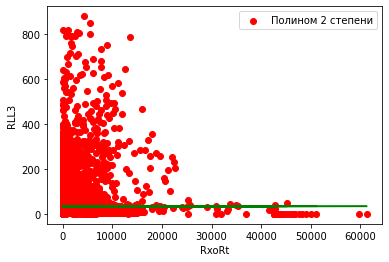

In [289]:
x_0=df_part1_clear['RxoRt'].values
y_0=df_part1_clear['RLL3'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x**2,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0**2, y_0, color='red')
plt.plot(x**2, y_pred,'g-')
plt.legend(['Полином 2 степени'])
plt.xlabel('RxoRt')
plt.ylabel('RLL3')

Попробовал провести Полиномиальную регрессию для этих же параметров. R^2 увеличился. 

In [280]:
x_0=df_part1_clear['RxoRt'].values
x_1=df_part1_clear['SP'].values
y_0=df_part1_clear['RLL3'].values

x=np.array([x_0, x_1]).reshape((-1, 2))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.009528422749383259
intercept(b_0):29.298408991594314
slope(b_1):-0.10346106369619902


После добавления параметра SP R^2 стал ещё меньше, попробую добавить больше параметров

In [84]:
x_0=df_part1_clear['RxoRt'].values
x_1=df_part1_clear['SP'].values
x_2=df_part1_clear['MN'].values
x_3=df_part1_clear['MCAL'].values
x_4=df_part1_clear['RHOB'].values
y_0=df_part1_clear['RLL3'].values

x=np.array([x_0, x_1,x_2,x_4]).reshape((-1, 4))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.016630021987329435
intercept(b_0):43.1392525021953
slope(b_1):0.01869162255395611


Когда строим линейную регрессию по 5 параметрам, то коэф. становится чуть лучше, но всё равно не устраивает нас

In [256]:
x_0=df_part1_clear['RxoRt'].values
x_1=df_part1_clear['SP'].values
x_2=df_part1_clear['MN'].values
x_3=df_part1_clear['MCAL'].values
x_4=df_part1_clear['RHOB'].values
x_5=df_part1_clear['RHOC'].values
x_6=df_part1_clear['GR'].values
y_0=df_part1_clear['RLL3'].values

x=np.array([x_0,x_1,x_2,x_3,x_4,x_5,x_6]).reshape((-1, 7))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.12550223853389608
intercept(b_0):39.25647645978522
slope(b_1):0.06777836574070599


Взял все переменные в первых степенях, получилось R^2=0.12 Лучше прежнего, но всё равно плохо.Попробуем посмотреть другие столбцы и поиграться со степенями переменных x_0,x_1 и т.д. Для регрессии по 7 переменным в первых степенях в данном примере получился наибольший коэффициент детерминации

In [88]:
x_0=df_part1_clear['RxoRt'].values
x_1=df_part1_clear['SP'].values
x_2=df_part1_clear['RLL3'].values
x_3=df_part1_clear['MCAL'].values
x_4=df_part1_clear['RHOB'].values
x_5=df_part1_clear['RHOC'].values
x_6=df_part1_clear['GR'].values
y_0=df_part1_clear['MN'].values

x=np.array([x_0,x_1,x_2,x_3,x_4,x_5,x_6]).reshape((-1, 7))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.11536225925832855
intercept(b_0):11.520217218045433
slope(b_1):0.12495014866245305


Если в качестве зависимой переменной выбрать MN , то результат чуть хуже. При подстановке для остальных переменных всё совсем плохо

In [112]:
x_0=df_part1_clear['RxoRt'].values
x_1=df_part1_clear['RLL3'].values
y_0=df_part1_clear['SP'].values

x=np.array([x_0, x_1]).reshape((-1, 2))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.016492611386688893
intercept(b_0):-95.03428066499797
slope(b_1):0.05001178953943732


Плохой коэф R^2 для 2 параметров RxoRt,RLL3 и завис. переменной SP. Попробуем поменять параметры 

In [281]:
x_0=df_part1_clear['MN'].values
x_1=df_part1_clear['MCAL'].values
y_0=df_part1_clear['SP'].values

x=np.array([x_0, x_1]).reshape((-1, 2))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.02296902306822657
intercept(b_0):-97.01026168989007
slope(b_1):0.1573034835770538


In [282]:
x_0=df_part1_clear['RHOB'].values
x_1=df_part1_clear['RHOC'].values
y_0=df_part1_clear['SP'].values

x=np.array([x_0, x_1]).reshape((-1, 2))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.2033978587792553
intercept(b_0):-74.94824783362452
slope(b_1):-0.6304664362348086


Коэф. детерминации 0.2 - уже чуть лучше. Поиграемся со степенями

In [283]:
x_0=df_part1_clear['RHOB'].values
x_1=df_part1_clear['RHOC'].values
y_0=df_part1_clear['SP'].values

x=np.array([x_0**(0.3), x_1**3]).reshape((-1, 2))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.301203455075274
intercept(b_0):-72.42506364184646
slope(b_1):7.570395105317398


Возвёл значения RHOC в 3 степень, из значений RHOB извлёк корень 3 степени. Получил коэф.детерминации 0.3 - лучше результата при данных переменных вроде как не удаётся добиться

coefficient of determination(R^2):0.1426799757911985
intercept(b_0):0.14369111942377522
slope(b_1):-0.0012815070574515525


Text(0, 0.5, 'RHOC')

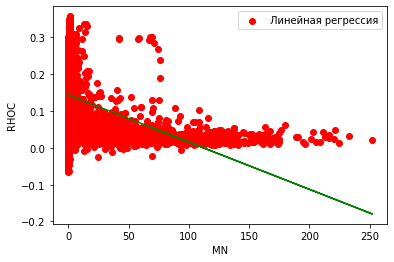

In [260]:
x_0=df_part1_clear['MN'].values
y_0=df_part1_clear['RHOC'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='red')
plt.plot( x, y_pred,'g-')
plt.legend(['Линейная регрессия'])
plt.xlabel('MN')
plt.ylabel('RHOC')

R^2=0.14

coefficient of determination(R^2):0.23371519933239693
intercept(b_0):0.3330046996608494
slope(b_1):-0.03459413307749731


Text(0, 0.5, 'RHOC')

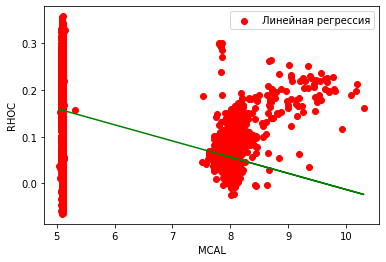

In [259]:
x_0=df_part1_clear['MCAL'].values
y_0=df_part1_clear['RHOC'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='red')
plt.plot( x, y_pred,'g-')
plt.legend(['Линейная регрессия'])
plt.xlabel('MCAL')
plt.ylabel('RHOC')

Коэф.детерминации 0.23 - самое большое значение для 1 независ переменной и другой завис. переменной RHOC

coefficient of determination(R^2):0.22003136720513894
intercept(b_0):0.1534444675610851
slope(b_1):-2.8894969350708163e-09


Text(0, 0.5, 'RLL3')

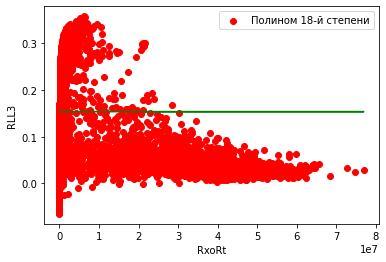

In [287]:
x_0=df_part1_clear['RHOB'].values
y_0=df_part1_clear['RHOC'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x**18,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0**18, y_0, color='red')
plt.plot( x**18, y_pred,'g-')
plt.legend(['Полином 18-й степени'])
plt.xlabel('RxoRt')
plt.ylabel('RLL3')

Выше использовал полином 18й степени потому что R^2 увеличивался с увеличением задаваемой степени переменной. Если брать степень выше, результат ухудшается 

coefficient of determination(R^2):0.011803364556516649
intercept(b_0):-26.251505358214807
slope(b_1):0.1008190173392593


Text(0, 0.5, 'RxoRt')

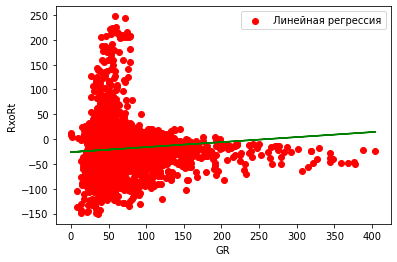

In [261]:
x_0=df_part1_clear['GR'].values
y_0=df_part1_clear['RxoRt'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='red')
plt.plot( x, y_pred,'g-')
plt.legend(['Линейная регрессия'])
plt.xlabel('GR')
plt.ylabel('RxoRt')

R^2=0.011 - низкий коэф.

Таким образом, наилучший коэффициент детерминации был получен при зависимой переменной SP, независимых RHOC,RHOB и равнен 0.3

Данный результат показывает, что не удалось подобрать зависимость, которая в адекватных пределах могла бы предсказывать величину того или иного параметра. Это связано с тем, что различные имеющиеся параметры относятся к различным методам, основывающихся на разнообразных физических явлениях. Поэтому все признаки описывают толщу горных пород с разных сторон, что и обуславливает их плохую зависимость друг от друга